<a href="https://colab.research.google.com/github/CassiaFa/Segmentation_lesion_pulmonaire/blob/main/Segmentation_lesion_pulmonaire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Partie 1 : Base de données

## Importation des packages

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm 

from sklearn.model_selection import train_test_split

In [3]:
os.chdir('/content/drive/MyDrive/Segmentation_lesion_pulmonaire/')
cwd = os.getcwd()
data_dir = os.path.join(cwd,"CT_Scan_Lesion_Segmentation","frames")
label_dir = os.path.join(cwd,"CT_Scan_Lesion_Segmentation","masks")

## Chargement et redimensionnage des images

In [4]:
Data = []
Label = []

width = 224
height = 224

for i in tqdm(os.listdir(data_dir)):
  # try:
    Data.append(cv2.resize(cv2.imread(os.path.join(data_dir, i)), (width, height))/255)
    # try:
    mask_o = cv2.resize(cv2.imread(os.path.join(label_dir, i), cv2.IMREAD_GRAYSCALE), (width, height))
    # except:
    #   print("\n", i, " - mask")
    mask = np.zeros(shape=(height, width, 1), dtype=np.float32)
    mask[:,:,0][mask_o==255]=1.
    Label.append(mask)
  # except:
  #   print("\n", i, " - data")
  

  

100%|██████████| 2729/2729 [14:50<00:00,  3.07it/s]


## Diviser les données en train/validation/test

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(Data, Label, train_size=.8)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=.9)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(Data, Label, train_size=.8)

In [6]:
Data = []
Label = []

## Visualisation des données et vérité terrain associé

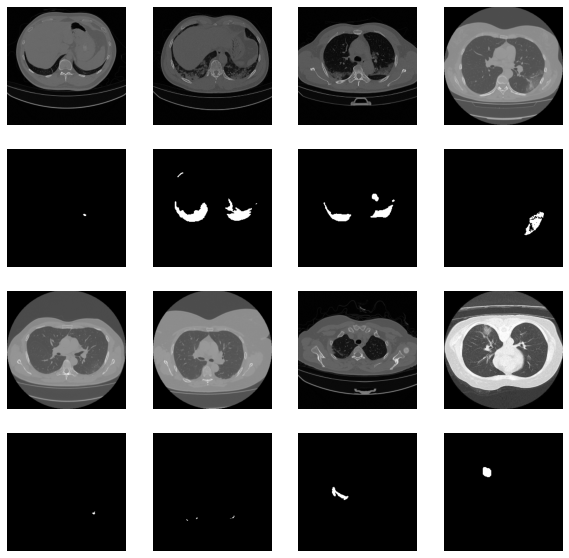

In [7]:
fig, axs = plt.subplots(4, 4, figsize = (10,10))

cpt = 0

for i in [0, 2]:
  for j in range(4):
    axs[i, j].imshow(X_train[cpt])
    axs[i, j].axis("off")
    axs[i+1, j].imshow(np.reshape(y_train[cpt],(width, height)), cmap="gray")
    axs[i+1, j].axis("off")
    plt.show

    cpt += 1

## Data Augmentation

In [8]:
from keras.preprocessing import image

X_train = np.array(X_train)
y_train = np.array(y_train)

# Creating the training Image and Mask generator
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

seed = 0
image_datagen.fit(X_train[:int(X_train.shape[0]*0.9)], augment=True, seed=seed)
mask_datagen.fit(y_train[:int(y_train.shape[0]*0.9)], augment=True, seed=seed)

BATCH_SIZE = 32
x=image_datagen.flow(X_train[:int(X_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(y_train[:int(y_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

In [9]:
# Creating the validation Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(X_train[int(X_train.shape[0]*0.9):], augment=True, seed=seed)
mask_datagen_val.fit(y_train[int(y_train.shape[0]*0.9):], augment=True, seed=seed)

x_val=image_datagen_val.flow(X_train[int(X_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_val.flow(y_train[int(y_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

In [10]:
#creating a training and validation generator that generate masks and images
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

# Partie 2 : Transfert Learning

In [11]:
!pip install segmentation-models

import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.7 MB/s 
Segmentation Models: using `keras` framework.


'tf.keras'

In [12]:
# from segmentation_models import Unet
from tensorflow.keras.metrics import BinaryIoU

model = sm.Unet('resnet34', encoder_weights='imagenet', classes=1, input_shape=(width,height, 3), activation='sigmoid')

85532672/85521592 [==============================] - 1s 0us/step


In [ ]:
# model.compile('Adam', loss="binary_crossentropy", metrics=["acc"])

# IoU = BinaryIoU(target_class_ids=[0, 1], threshold=0.5)
# model.compile('Adam', loss="binary_crossentropy", metrics=[IoU]) # metric IoU

# results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=500, steps_per_epoch=1000,epochs=10)
# model.save_weights('Unet_weights.hdf5')
# model.save('Unet_weights.h5')

85532672/85521592 [==============================] - 4s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/10
1000/1000 [==============================] - 642s 622ms/step - loss: 0.0363 - binary_io_u: 0.7368 - val_loss: 0.0202 - val_binary_io_u: 0.7342
Epoch 2/10
1000/1000 [==============================] - 613s 613ms/step - loss: 0.0143 - binary_io_u: 0.8267 - val_loss: 0.0108 - val_binary_io_u: 0.8507
Epoch 3/10
1000/1000 [==============================] - 607s 607ms/step - loss: 0.0125 - binary_io_u: 0.8422 - val_loss: 0.0117 - val_binary_io_u: 0.8515
Epoch 4/10
1000/1000 [==============================] - 633s 633ms/step - loss: 0.0119 - binary_io_u: 0.8464 - val_loss: 0.0127 - val_binary_io_u: 0.8327
Epoch 5/10
1000/1000 [==============================] - 606s 607ms/step - loss: 0.0112 - binary_io_u: 0.8535 - val_loss: 0.0096 - val_binary_io_u: 0.8671
Epoch 6/10
1000/1000 [==============================] - 630s 630ms/step - loss: 0.0104 - binary_io_u: 0.8596 - val_loss: 0.0106 - val_binary_io_u: 0.8590
Epoch 7/10
1000/1000 [==============================] - 607s 607ms/step - lo

In [13]:
model.load_weights("Unet_weights.hdf5")

In [14]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [15]:
# Prediction

X_pred = model.predict(X_test)

(-0.5, 223.5, 223.5, -0.5)

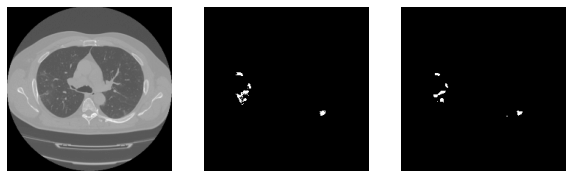

In [16]:
from IPython.core.pylabtools import figsize
fig, axs = plt.subplots(1, 3, figsize=(10,15))
axs[0].imshow(X_test[0,:,:,0], cmap='gray')
axs[0].axis("off")
axs[1].imshow(y_test[0,:,:,0], cmap='gray')
axs[1].axis("off")
axs[2].imshow(X_pred[0,:,:,0]>=0.5, cmap='gray')
axs[2].axis("off")

In [17]:
def SEG_EVAL(Seg,GT):
    # Seg : Segmented image, must be binary (1 = regions of interest 0 = background)
    # GT : Ground truth, must be binary (1 = regions of interest 0 = background)
    Seg.astype(np.bool)
    GT.astype(np.bool)
    
    #dice_coefficient
    intersection = np.logical_and(Seg, GT)
    dice_coefficient = 2. * intersection.sum() / (Seg.sum() + GT.sum())
    
    #IoU
    TP = np.logical_and(Seg, GT)
    IoU = TP.sum() / (GT.sum() + Seg.sum() - TP.sum())
    
    #recall
    recall = TP.sum() / GT.sum()
    
    #precision
    precision = TP.sum() / Seg.sum()
    
    EVAL = [dice_coefficient,IoU,recall,precision]
    
    return EVAL

In [18]:
def VIS_EVAL(Image, Seg, GT, option = 'contour'):
    # Image : Gray image
    # Seg : Segmented image, must be binary (1 = regions of interest 0 = background)
    # GT : Ground truth, must be binary (1 = regions of interest 0 = background)
    # option = 'contour' For contour plotting
    # option = 'region' For color the region
       
    Image = cv2.cvtColor(np.array(Image, np.uint8), cv2.COLOR_GRAY2RGB)
    GT = np.array(255*GT, dtype=np.uint8)
    Seg = np.array(255*Seg, dtype=np.uint8)
    GT = cv2.cvtColor(GT, cv2.COLOR_GRAY2RGB)
    Seg = cv2.cvtColor(Seg, cv2.COLOR_GRAY2RGB)
        
    if option == 'region':
        GT[:, :, 1:2] = 0*GT[:, :, 1:2]
        Seg[:, :, 0] = 0*Seg[:, :, 0]
        Seg[:, :, 2] = 0*Seg[:, :, 2]
        
        VIS_Seg = cv2.addWeighted(Image, 1, Seg, 0.5, 0)
        VIS_GT = cv2.addWeighted(Image, 1, GT, 0.5, 0)
          
    elif option == 'contour':
       
        contours_GT = cv2.Canny(GT, 250, 260) 
        contours_Seg = cv2.Canny(Seg, 250, 260) 
        
        contours_GT = cv2.cvtColor(contours_GT, cv2.COLOR_GRAY2RGB)
        contours_Seg = cv2.cvtColor(contours_Seg, cv2.COLOR_GRAY2RGB)
        
        contours_GT[:, :, 1:2] = 0*contours_GT[:, :, 1:2]
        contours_Seg[:, :, 0] = 0*contours_Seg[:, :, 0]
        contours_Seg[:, :, 2] = 0*contours_Seg[:, :, 2]
        
        VIS_Seg = cv2.addWeighted(Image, 1, contours_Seg, 0.5, 0)
        VIS_GT = cv2.addWeighted(Image, 1, contours_GT, 0.5, 0)
        
    return VIS_Seg,VIS_GT

In [19]:
id = 1
Image = X_test[id,:,:,0]
Seg = (X_pred[id,:,:,0]>=0.5).astype(int)
GT = y_test[id,:,:,0]

VIS_Seg, VIS_GT = VIS_EVAL(Image, Seg, GT, option = 'region')

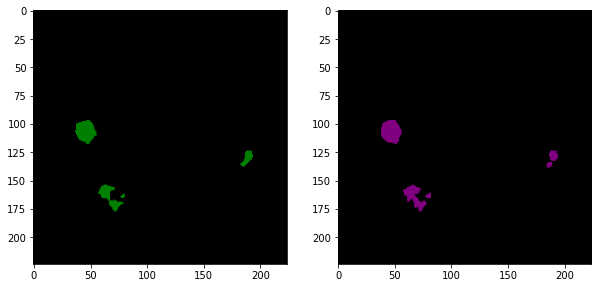

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10,15))
axs[0].imshow(VIS_Seg)
axs[1].imshow(VIS_GT)

In [21]:
eval = []

for i, tf in zip(X_pred, y_test):
  Seg = ((i)>=0.5).astype(int)
  eval.append(SEG_EVAL(Seg,tf.astype(int)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid

In [22]:
eval_array = np.array(eval)

In [23]:
np.nanmean(eval_array, axis=0)

array([0.78226043, 0.67763366, 0.7508679 , 0.86664088])

In [24]:
for i, tf in zip(X_pred, y_test):
  Seg = ((i)>=0.5).astype(int)
  print(SEG_EVAL(Seg,tf.astype(int)))

  break

[0.7405405405405405, 0.5879828326180258, 0.6431924882629108, 0.8726114649681529]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [25]:
np.isnan(eval_array).sum(axis=0)

array([ 1,  1,  1, 15])